In [1]:
# Parameters

# Directory with cloned repository https://github.com/COST-ELTeC/ELTeC-eng
eltec_dir = "."

# File with filenames
metadata_file = "ELTeC-eng_metadata.xlsx"
metadata_filename_column = "filename"

In [16]:
import pandas as pd
import xml.etree.ElementTree as ET

def parse_file_to_df(filename):
    tree = ET.parse(eltec_dir + '/ELTeC-eng/level1/' + filename + '.xml')
    namespace = {"tei": "http://www.tei-c.org/ns/1.0"}
    root = tree.getroot()

    def get_plain_text(element):
        result = []

        # Add root text (text before any child element) if present
        if element.text:
            result.append(element.text)

        # Iterate over the elements inside <p>
        for elem in element:
            if elem.text:  # If the tag has inner text, append it
                result.append(elem.text)
            if elem.tail:  # If the tag has trailing text, append it
                result.append(elem.tail)

        # Join and return the processed text
        return ''.join(result)

    body = root.find('.//tei:body', namespace)
    if body is not None:
        p_values = [get_plain_text(p) for p in body.findall('.//tei:p', namespace)]
    else:
        p_values = []

    df = pd.DataFrame(p_values, columns=[filename])

    print(df.info)
    print(df.head())

    return df

In [17]:
from helpers.TextManipulations import split_text_into_sentences
from helpers.TextManipulations import perform_text_preprocessing
from algorithms.MAL.MAL import create_sentences_length_in_paragraph_dict
from algorithms.MAL.MAL import perform_word_split
from algorithms.MAL.MAL import create_words_length_in_sentence_dict
from algorithms.MAL.MAL import count_sentences_length_in_paragraph_dict
from algorithms.MAL.MAL import average_sentences_length_in_paragraph_dict_single
from algorithms.MAL.MAL import average_sentences_length_in_paragraph_dict
from algorithms.MAL.MAL import print_sorted
from algorithms.MAL.MAL import perform_syllable_split
from algorithms.MAL.MAL import create_words_length_in_sentence_dict
from algorithms.MAL.MAL import count_sentences_length_in_paragraph_dict
from algorithms.MAL.MAL import average_sentences_length_in_paragraph_dict_single
from algorithms.MAL.MAL import average_sentences_length_in_paragraph_dict
from algorithms.MAL.MAL import perform_phoneme_split
from algorithms.MAL.MAL import count_sentences_length_in_paragraph_dict
from algorithms.MAL.MAL import average_sentences_length_in_paragraph_dict_single
from algorithms.MAL.MAL import average_sentences_length_in_paragraph_dict
from algorithms.MAL.MAL import find_A_b_numerically_truncated
from algorithms.MAL.MAL import find_A_b_numerically_full

def perform_mal(paragraphs)-> float:
    #print("Paragraphs")
    #print(paragraphs)
    sentences = [split_text_into_sentences(element) for element in paragraphs]
    #print("Sentences")
    #print(sentences)
    sentences_normalized = [[perform_text_preprocessing(string) for string in inner_list] for inner_list in sentences]
    #print("Sentences Normalized")
    #print(sentences_normalized)
    sentences_dict = create_sentences_length_in_paragraph_dict(sentences_normalized)
    sentences_dict.pop(0, None) # remove sentence of length zero if encountered
    #print("Sentences Dict")
    #print(sentences_dict)
    sentences_dict_split = perform_word_split(sentences_dict)
    #print("sentences_dict_split")
    #print(sentences_dict_split)
    words_dict = create_words_length_in_sentence_dict(sentences_dict_split)
    words_dict.pop(0, None) # remove sentence of length zero if encountered
    #print("words_dict")
    #print(words_dict)
    sentences_dict_split_counted = count_sentences_length_in_paragraph_dict(sentences_dict_split) 
    #print("sentences_dict_split_counted")
    #print(sentences_dict_split_counted)
    sentences_dict_split_counted_average_single = average_sentences_length_in_paragraph_dict_single(sentences_dict_split_counted) 

    # Level 1: Paragraph - Sentence - Word (X_1, Y_1)
    X_1_Y_1 = average_sentences_length_in_paragraph_dict(sentences_dict_split_counted_average_single) 
    # Level 2: Sentence - Word - Syllable (X_2, Y_2)
    words_dict_split = perform_syllable_split(words_dict)
    #print("words_dict_split")
    #print(words_dict_split)
    syllables_dict = create_words_length_in_sentence_dict(words_dict_split) 
    syllables_dict.pop(0, None) # remove word of length zero if encountered
    #print("syllables_dict")
    #print(syllables_dict)
    words_dict_split_counted = count_sentences_length_in_paragraph_dict(words_dict_split) 
    words_dict_split_counted_average_single = average_sentences_length_in_paragraph_dict_single(words_dict_split_counted) 
    X_2_Y_2 = average_sentences_length_in_paragraph_dict(words_dict_split_counted_average_single) 
    syllables_dict_split = perform_phoneme_split(syllables_dict)
    syllables_dict_split_counted = count_sentences_length_in_paragraph_dict(syllables_dict_split) 

    # Level 3: Word - Syllable - Phoneme (X_3, Y_3)
    syllables_dict_split_counted_average_single = average_sentences_length_in_paragraph_dict_single(syllables_dict_split_counted) 
    X_3_Y_3 = average_sentences_length_in_paragraph_dict(syllables_dict_split_counted_average_single) 
    #print_sorted(X_3_Y_3)

    a_1, b_1 = find_A_b_numerically_truncated(X_1_Y_1)
    #print(b_1)
    a_2, b_2 = find_A_b_numerically_truncated(X_2_Y_2)
    #print(b_2)
    a_3, b_3 = find_A_b_numerically_truncated(X_3_Y_3)
    #print(b_3)

    D_trun = 3 / (b_1 + b_2 + b_3)

    a_1, b_1, c_1 = find_A_b_numerically_full(X_1_Y_1)
    #print(b_1)
    a_2, b_2, c_2 = find_A_b_numerically_full(X_2_Y_2)
    #print(b_2)
    a_3, b_3, c_3 = find_A_b_numerically_full(X_3_Y_3)
    #print(b_3)

    D_full = 3 / (b_1 + b_2 + b_3)
    return D_trun, D_full

In [18]:
def clean_and_convert_to_list(series):
    nonan_series = series.dropna()
    result = nonan_series.astype(str).values.flatten().tolist()
    return result

In [19]:
def get_text_columns_from_file(metadata_file):
    metadata_df = pd.read_excel(metadata_file)

    text_columns = metadata_df[metadata_filename_column].tolist()

    return text_columns

In [20]:
text_columns = get_text_columns_from_file(metadata_file)
dfs = [parse_file_to_df(column) for column in text_columns]

D_trun_s = []
D_full_s = []
for idx, df in enumerate(dfs):
    #print(f"Processing DataFrame {idx + 1}...")
    #print(df.columns)
    D_trun, D_full = perform_mal(clean_and_convert_to_list(df))
    D_trun_s.append(D_trun)
    D_full_s.append(D_full)

print(D_trun_s)
print(D_full_s)

<bound method DataFrame.info of                                         ENG19004_Fowler
0     In the middle of Sedgehill, which is in the mi...
1     In the dark valley lying to the immediate east...
2     The home of the Farringdons was called the Wil...
3     Moreover, the Farringdons were of "the people ...
4     At the time when this story begins, the joint ...
...                                                 ...
2046                                     "White satin."
2047  Mrs. Hankey gazed critically at the bride-elec...
2048  "Certainly not," Christopher agreed. "If there...
2049  "And that's easy enough for some of us, such a...
2050  So the women talked and the men listened—as is...

[2051 rows x 1 columns]>
                                     ENG19004_Fowler
0  In the middle of Sedgehill, which is in the mi...
1  In the dark valley lying to the immediate east...
2  The home of the Farringdons was called the Wil...
3  Moreover, the Farringdons were of "the people ...
4  At

Outliers:
Label: ENG18610_Eliot, Value: 261.96775123762507


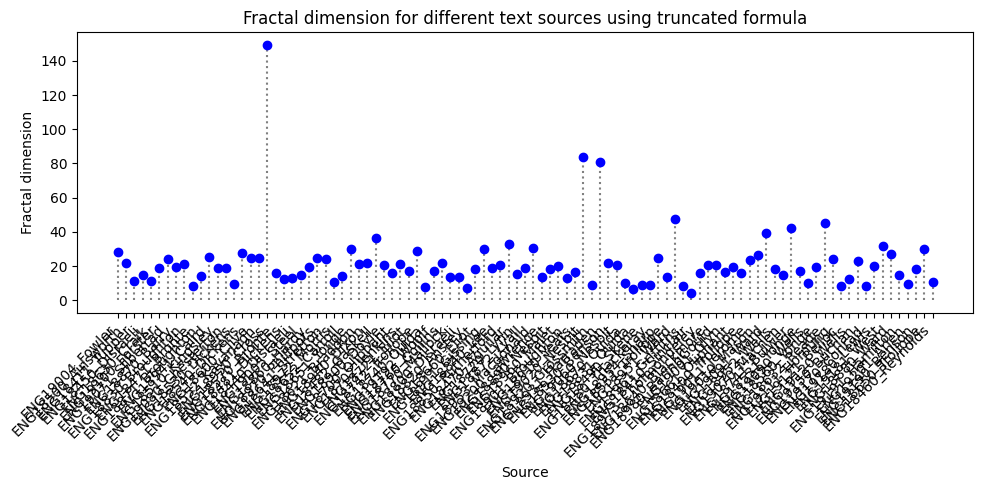

Outliers:
Label: ENG18610_Eliot, Value: 262.01983732764774
Label: ENG19200_Lawrence, Value: 999999.9999999471
Label: ENG19150_Buchan, Value: 999999.9999750814


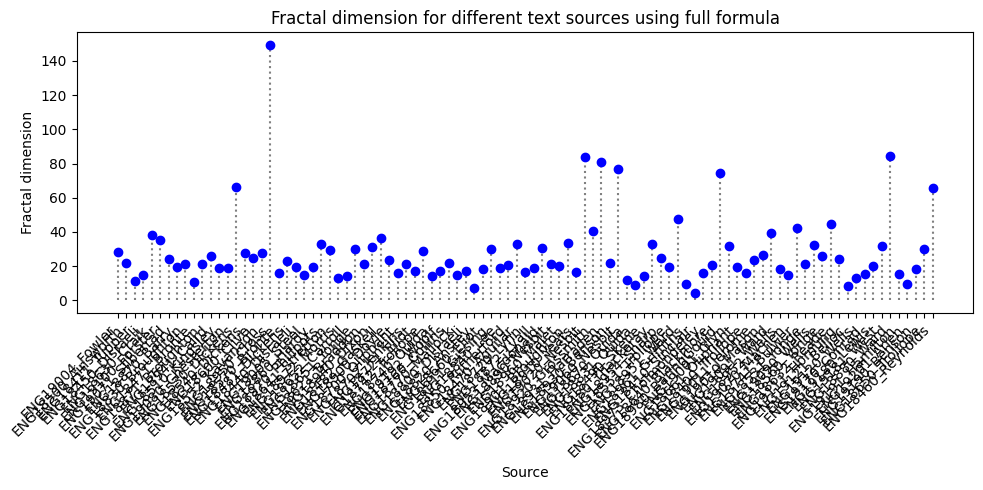

In [24]:
import matplotlib.pyplot as plt

def plot_scatter(D_s, text_columns, title, algorithm, threshold=None):
    filtered_data = []
    filtered_labels = []
    outliers = []

    for value, label in zip(D_s, text_columns):
        if threshold is not None and value > threshold:
            outliers.append((label, value))
        else:
            filtered_data.append(value)
            filtered_labels.append(label)

    if outliers:
        print("Outliers:")
        for label, value in outliers:
            print(f"Label: {label}, Value: {value}")
            
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(filtered_data)), filtered_data, color='blue', zorder=5)

    plt.xticks(range(len(filtered_labels)), filtered_labels, rotation=45, ha="right")

    plt.xlabel('Source')
    plt.ylabel('Fractal dimension')
    plt.title(title)
    
    for i, label in enumerate(filtered_labels):
        plt.vlines(i, ymin=0, ymax=filtered_data[i], colors='gray', linestyles='dotted')

    plt.tight_layout()
    plt.savefig(f'dane_wiki_final_{algorithm}.png')
    plt.show()

plot_scatter(D_trun_s, text_columns, 'Fractal dimension for different text sources using truncated formula', 'MAL', 200)
plot_scatter(D_full_s, text_columns, 'Fractal dimension for different text sources using full formula', 'MAL', 200)